In [1]:
from optionCombo import optionModel,preInit

C:\Users\5565\AppData\Local\Programs\Python\Python310\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


# Collect Deribit option data

In [2]:
import requests
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from datetime import datetime
import random
import time
from tqdm.notebook import tqdm
#most of the code comes from this repo https://github.com/schepal/deribit_data_collector/blob/master/deribit_data.py

def request_get(url):
    while True:
        try:
            page = requests.get(url)
            return page.json()['result']
        except:time.sleep(random.randint(1,5))
        
def get_options_list():
    data = {'currency': currency, 'kind': 'option'}
    r = requests.get(url + 'get_instruments', data)
    df = pd.DataFrame(r.json()['result'])
    cols = ['expiration_timestamp', 'option_type', 'instrument_name', 'strike']
    return df[cols]
def get_option_urls():
    url_storage = []
    options_list = get_options_list()
    request_url = url + 'get_order_book?instrument_name='
    for option in range(len(options_list)):
        data = request_url + options_list.instrument_name.values[option]
        url_storage.append(data)
    return url_storage
def collect_clean_data():

    raw_data = []
    pool = ThreadPoolExecutor(max_workers=10)
    print("Collecting data...")
    urls = get_option_urls()
    for asset in tqdm(pool.map(request_get,urls ),total=len(urls)):
        raw_data.append(asset)
    data = pd.DataFrame(raw_data)

    option_data = data
    option_data['infos'] = option_data['instrument_name'].apply(lambda x: x.split('-'))
    option_data['expiration'] = option_data['infos'].apply(
        lambda x: pd.to_datetime(x[1]))  # pd.to_datetime(option_data['expiration'])#
    option_data['is_call'] = option_data['infos'].apply(lambda x: x[-1])
    option_data['K'] = option_data['infos'].apply(lambda x: x[-2])
    option_data['ticker'] = option_data['infos'].apply(lambda x: x[0])
    option_data['askIv'] = option_data['ask_iv'] / 100  # option_data['askIV']#
    option_data['bidIv'] = option_data['bid_iv'] / 100  # option_data['bidIV']#
    option_data[['K', 'bidIV', 'askIV']] = option_data[['K', 'bidIv', 'askIv']].astype('float')

    option_data['expiry'] = option_data['expiration'].apply(lambda x: (pd.to_datetime(x) - datetime.now()) / (pd.to_timedelta('365d')))

    option_data = option_data[['is_call','K','askIV','bidIV','expiry','expiration']]
    expirList = option_data.sort_values(by=['expiration'])['expiration'].unique()


    return option_data,expirList

In [3]:
global currency
global url
currency = 'BTC'
url = 'https://www.deribit.com/api/v2/public/'
option_data,expirList = collect_clean_data()

  0%|          | 0/866 [00:00<?, ?it/s]

In [4]:
expirList

<DatetimeArray>
['2023-06-24 00:00:00', '2023-06-25 00:00:00', '2023-06-26 00:00:00',
 '2023-06-30 00:00:00', '2023-07-07 00:00:00', '2023-07-14 00:00:00',
 '2023-07-28 00:00:00', '2023-08-25 00:00:00', '2023-09-29 00:00:00',
 '2023-12-29 00:00:00', '2024-03-29 00:00:00', '2024-06-28 00:00:00']
Length: 12, dtype: datetime64[ns]

In [5]:
# choose a expiry date, doesn't support mutiple expiry dates at the moment
expirDate = '2023-06-30T00:00:00.000000000'

In [6]:
# this is what the option Dataframe should look like 
option_data

,is_call,K,askIV,bidIV,expiry,expiration
0,C,25500.0,0.0000,0.0000,-0.001478,2023-06-24
1,P,25500.0,4.7175,0.0000,-0.001478,2023-06-24
2,C,26000.0,0.0000,0.0000,-0.001478,2023-06-24
3,P,26000.0,4.2892,0.0000,-0.001478,2023-06-24
4,C,26500.0,0.0000,0.0000,-0.001478,2023-06-24
...,...,...,...,...,...,...
861,P,95000.0,0.0000,0.0000,1.012221,2024-06-28
862,C,100000.0,0.7117,0.6836,1.012221,2024-06-28
863,P,100000.0,0.0000,0.0000,1.012221,2024-06-28
864,C,120000.0,0.7320,0.7140,1.012221,2024-06-28


# Collect price data, this is used for determine asset price range

In [7]:
import ccxt
def fetchprice(symbol,exchange = 'binance'):
    res = {}
    exchange = getattr(ccxt, exchange)()


    while True:
        try:
            data = exchange.fetch_ohlcv(symbol, '15m', None, 1000)
            header = ["Timestamp", "open", "high", "low", "close", "volume"]
            df = pd.DataFrame(data, columns=header)
            df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
            break
        except Exception as e:
            print(e)
            time.sleep(1)
    for i in range(20):
        while True:
            try:
                since = df.Timestamp.values[0] - 1000*15*60*1000
                data = exchange.fetch_ohlcv(symbol, '15m', since, 1000)
                header = ["Timestamp", "open", "high", "low", "close", "volume"]
                df1 = pd.DataFrame(data, columns=header)
                df1 = df1[["Timestamp", "open", "high", "low", "close", "volume"]]
                df = pd.concat([df1,df]).reset_index(drop=True)
                break
            except Exception as e:
                print(e)
                time.sleep(1)
    df = df[["Timestamp", "open", "high", "low", "close", "volume"]]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'] / 1000, unit="s")
    df["open"] = pd.to_numeric(df["open"])
    df["high"] = pd.to_numeric(df["high"])
    df["low"] = pd.to_numeric(df["low"])
    df["close"] = pd.to_numeric(df["close"])
    df["volume"] = pd.to_numeric(df["volume"])
    return df

In [8]:
pricedata = fetchprice('BTCUSDT')

In [9]:
# this is what the price Dataframe should look like 
pricedata

,Timestamp,open,high,low,close,volume
0,2022-11-17 11:00:00,16526.51,16595.00,16523.45,16575.05,2683.67471
1,2022-11-17 11:15:00,16574.05,16606.68,16561.48,16570.75,2048.26341
2,2022-11-17 11:30:00,16570.75,16590.48,16565.00,16580.76,1764.62653
3,2022-11-17 11:45:00,16580.05,16615.99,16575.21,16595.08,2311.06759
4,2022-11-17 12:00:00,16594.19,16604.71,16575.00,16580.40,2163.90732
...,...,...,...,...,...,...
20995,2023-06-24 03:45:00,30747.42,30750.00,30711.88,30730.01,184.94755
20996,2023-06-24 04:00:00,30730.00,30730.01,30655.35,30686.31,207.07959
20997,2023-06-24 04:15:00,30686.31,30753.35,30686.30,30728.58,151.57763
20998,2023-06-24 04:30:00,30728.57,30750.00,30715.88,30716.01,132.61227


In [10]:
# this part of the code is for pre-compute

preOption,joined1,price = preInit.Prep( expirDate, optionDf = option_data, priceDf = pricedata, interval=3, strikePriceRange=0.2)

C:\Users\5565\AppData\Local\Programs\Python\Python310\lib\site-packages\optionCombo\preInit.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_data['per_ivs'] = option_data['bidIV'].apply(lambda x: list(np.linspace(1 * lowerIV, 1 * upperIV, 89)), 0)


In [11]:
# this part of the code is for loop through all the possible option combination of 4 call options, 1 stands for call option
# -1 stands for put options, possible input for "optiontypes" should be a two dimension list, eg. [[1,1,1],[-1,-1,1,1]]
# tradetypes is sell or buy options correspondingly, eg. if optiontypes =[[1,1,1]], tradetypes should be [[1,-1,1]] or 
#[[[1,-1,1],[1,1,1]]], tradetypes is None by default to include all combinations
# maxquantity is the input for maxmium possible quantity for a single option trade amount 

model = optionModel.option_model(price, joined1,preOption,optiontypes = [[1,1,1,1],[-1,-1,1,1]],tradetypes=[[1,-1,-1,1],[[1,-1,-1,1]]], maxquantity=1)  # Init
df = model.options_model_finder()                                                                           # start looping

100%|█████████████████████████████████████████████████████████████████████████████| 6931/6931 [00:58<00:00, 119.13it/s]


In [12]:
# output contains all the possible combinations given the parameters, you can filter out the result as you want
df

,para,stra,maxRisk,probal,RR,wv,wp,bv,bp,delta_starting,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium
0,"[30715.85, [0.01496075075767377, 0.01496075075...",C_28500_1__C_30500_-1__C_31000_-1__C_33000_1,1.000000,0.067416,0.050457,0.85,26498.465807,0.85,30558.188694,0.144686,0.275013,0.292872,5.860084,-106.737295,29.248419,4669.003638
1,"[30715.85, [0.01496075075767377, 0.01496075075...",C_29000_1__C_30500_-1__C_31500_-1__C_33000_1,1.000000,0.134831,0.160307,0.85,26498.465807,0.85,30558.188694,0.035090,0.207531,0.225199,4.204913,-59.545354,22.634663,3703.957310
2,"[30715.85, [0.01496075075767377, 0.01496075075...",C_29500_1__C_30500_-1__C_31000_-1__C_32000_1,1.000000,0.000000,0.082210,0.85,26498.465807,0.85,30558.188694,0.094159,0.171152,0.187282,5.055437,-76.689463,20.574133,3854.644320
3,"[30715.85, [0.01496075075767377, 0.01496075075...",C_29500_1__C_30500_-1__C_32000_-1__C_33000_1,1.000000,0.000000,0.203827,0.85,26498.465807,0.85,30558.188694,0.013857,0.195238,0.209559,5.256570,-80.361771,17.675015,3408.596774
4,"[30715.85, [0.01496075075767377, 0.01496075075...",C_30000_1__C_30500_-1__C_31000_-1__C_31500_1,1.000000,0.000000,0.322230,0.85,26498.465807,0.85,30558.188694,0.051580,0.121097,0.133484,4.382317,-58.843198,16.218986,3502.784330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6926,"[30715.85, [0.01496075075767377, 0.01496075075...",P_29500_4__P_30000_-4__C_31500_-4__C_32000_3,5.115880,0.202247,0.195470,0.85,37005.983867,0.85,30080.574237,0.248591,0.643238,0.579931,-4.471826,6.220491,48.258454,5235.739898
6927,"[30715.85, [0.01496075075767377, 0.01496075075...",P_29500_4__P_30500_-4__C_31000_-4__C_32000_3,2.456045,0.168539,0.407159,0.85,37005.983867,0.85,30558.188694,0.234211,0.737854,0.682460,-3.730492,-1.101897,66.192521,6696.064089
6928,"[30715.85, [0.01496075075767377, 0.01496075075...",P_29500_4__P_30500_-4__C_32000_-4__C_33000_3,3.446986,0.224719,0.290109,0.85,37005.983867,0.85,30558.188694,0.200497,0.784385,0.795690,-3.723217,-8.688264,85.218972,5051.680035
6929,"[30715.85, [0.01496075075767377, 0.01496075075...",P_30000_4__P_30500_-4__C_31000_-4__C_31500_3,3.521524,0.123596,0.283968,0.85,37005.983867,0.85,30558.188694,0.334098,0.611405,0.519696,-4.090175,5.889975,35.688247,7641.871960


In [13]:
temp = df.loc[  (df['probal']>0.5)&(df['mean_vega']>0)].sort_values(by=['probal','mean_vega'], ascending=[False,False])
temp

,para,stra,maxRisk,probal,RR,wv,wp,bv,bp,delta_starting,mean_delta,std_delta,mean_vega,mean_theta,std_theta,premium
5733,"[30715.85, [0.01496075075767377, 0.01496075075...",P_30000_4__P_30500_-1__C_31000_-1__C_31500_4,1.203598,0.685393,5.062744,0.85,31513.417608,0.85,37005.983867,0.056066,2.062886,2.172808,40.033830,-186.567031,132.268464,4583.596469
4261,"[30715.85, [0.01496075075767377, 0.01496075075...",P_30000_3__P_30500_-1__C_31000_-1__C_31500_3,1.337276,0.685393,4.855410,0.85,31513.417608,0.85,37005.983867,0.038900,1.363543,1.437986,26.925608,-126.595474,87.688680,3728.382607
2622,"[30715.85, [0.01496075075767377, 0.01496075075...",P_29000_1__P_30000_-4__C_32000_-1__C_33000_4,10.423132,0.685393,1.145522,0.85,26498.465807,0.85,37005.983867,1.489796,2.164821,0.595570,7.527041,-64.190675,131.622724,2706.824702
3979,"[30715.85, [0.01496075075767377, 0.01496075075...",P_29000_2__P_30000_-4__C_32000_-1__C_33000_3,8.395237,0.685393,0.990729,0.85,26498.465807,0.85,37005.983867,1.154117,1.530865,0.443782,5.476922,-52.063479,86.207841,2755.697982
3689,"[30715.85, [0.01496075075767377, 0.01496075075...",P_28000_2__P_28500_-3__C_31500_-2__C_32000_3,52.565848,0.685393,1.379059,0.85,26498.465807,0.85,37005.983867,0.273030,0.657422,0.258598,2.801364,-22.800416,50.883944,2277.107820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,"[30715.85, [0.01496075075767377, 0.01496075075...",P_29000_1__P_30000_-2__C_32000_-2__C_33000_3,5.956900,0.505618,0.688303,0.85,26498.465807,0.85,37005.983867,0.422503,0.629449,0.319875,4.391511,-41.033646,67.340732,2026.363706
1949,"[30715.85, [0.01496075075767377, 0.01496075075...",P_28500_1__P_29500_-2__C_32000_-2__C_33000_3,7.733239,0.505618,0.695440,0.85,26498.465807,0.85,37005.983867,0.295077,0.578578,0.328486,4.238913,-39.315356,72.018057,1717.600520
5542,"[30715.85, [0.01496075075767377, 0.01496075075...",P_29000_3__P_30000_-4__C_31000_-3__C_32000_4,3.355281,0.505618,0.698534,0.85,26498.465807,0.85,37005.983867,0.484955,0.798064,0.391638,4.230212,-41.819030,62.199165,5147.206321
5536,"[30715.85, [0.01496075075767377, 0.01496075075...",P_28500_3__P_29500_-4__C_31000_-3__C_32000_4,4.107629,0.505618,0.659066,0.85,26498.465807,0.85,37005.983867,0.279320,0.736658,0.433299,3.701029,-38.989208,71.911551,4469.730563


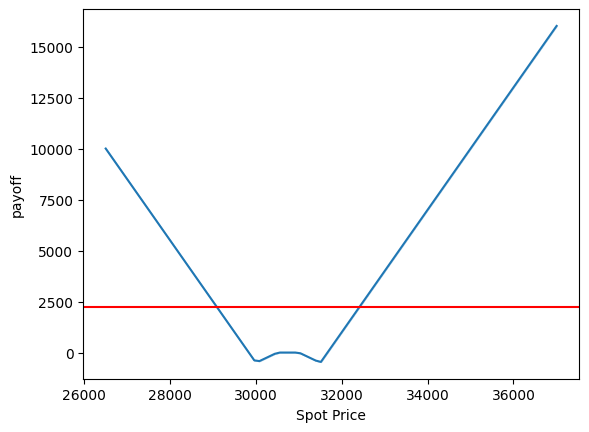

net premium 2258.114432330449
premium 4583.596469322046
Risk Reward 5.062743861824781
probal 0.6853932584269663
lowest possible premium -459.7471747881609
max risk [1.20359782]
worst case, vol: 0.85 price: 31513.417608403946
best case, vol: 0.85 price: 37005.98386701981
min theta -390.2222485431408
min vega 1.9451528389932462
P_30000_4__P_30500_-1__C_31000_-1__C_31500_4
[{'type': 'P', 'strike': 30000.0, 'expiry': 0.01496075075767377, 'vol': 0.4938, 'quantity': 4, 'map': 1}, {'type': 'P', 'strike': 30500.0, 'expiry': 0.01496075075767377, 'vol': 0.4628, 'quantity': -1, 'map': -1}, {'type': 'C', 'strike': 31000.0, 'expiry': 0.01496075075767377, 'vol': 0.46990000000000004, 'quantity': -1, 'map': -1}, {'type': 'C', 'strike': 31500.0, 'expiry': 0.01496075075767377, 'vol': 0.4975, 'quantity': 4, 'map': 1}]


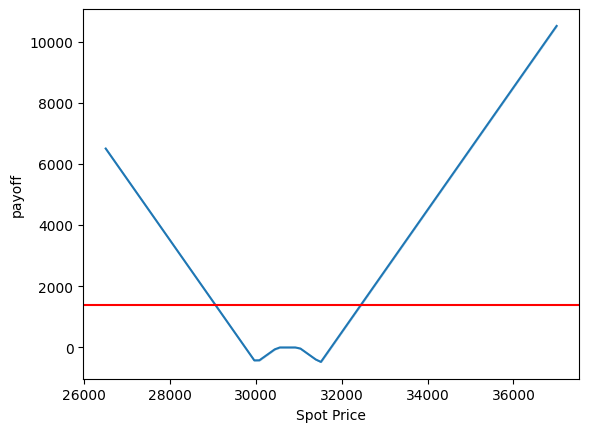

net premium 1402.900569623887
premium 3728.3826066154834
Risk Reward 4.8554103676308085
probal 0.6853932584269663
lowest possible premium -473.1647831921073
max risk [1.33727606]
worst case, vol: 0.85 price: 31513.417608403946
best case, vol: 0.85 price: 37005.98386701981
min theta -259.3923890625591
min vega 1.4115591509581686
P_30000_3__P_30500_-1__C_31000_-1__C_31500_3
[{'type': 'P', 'strike': 30000.0, 'expiry': 0.01496075075767377, 'vol': 0.4938, 'quantity': 3, 'map': 1}, {'type': 'P', 'strike': 30500.0, 'expiry': 0.01496075075767377, 'vol': 0.4628, 'quantity': -1, 'map': -1}, {'type': 'C', 'strike': 31000.0, 'expiry': 0.01496075075767377, 'vol': 0.46990000000000004, 'quantity': -1, 'map': -1}, {'type': 'C', 'strike': 31500.0, 'expiry': 0.01496075075767377, 'vol': 0.4975, 'quantity': 3, 'map': 1}]


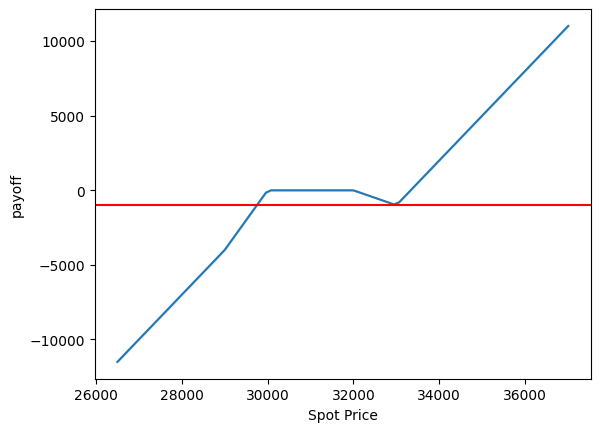

net premium -1007.132102640762
premium 2706.824701624356
Risk Reward 1.1455220313297438
probal 0.6853932584269663
lowest possible premium -11504.602578822909
max risk [10.42313163]
worst case, vol: 0.85 price: 26498.46580705903
best case, vol: 0.85 price: 37005.98386701981
min theta -256.3537314179797
min vega -32.65360214782546
P_29000_1__P_30000_-4__C_32000_-1__C_33000_4
[{'type': 'P', 'strike': 29000.0, 'expiry': 0.01496075075767377, 'vol': 0.5418999999999999, 'quantity': 1, 'map': 1}, {'type': 'P', 'strike': 30000.0, 'expiry': 0.01496075075767377, 'vol': 0.4725, 'quantity': -4, 'map': -1}, {'type': 'C', 'strike': 32000.0, 'expiry': 0.01496075075767377, 'vol': 0.4849, 'quantity': -1, 'map': -1}, {'type': 'C', 'strike': 33000.0, 'expiry': 0.01496075075767377, 'vol': 0.5521, 'quantity': 4, 'map': 1}]


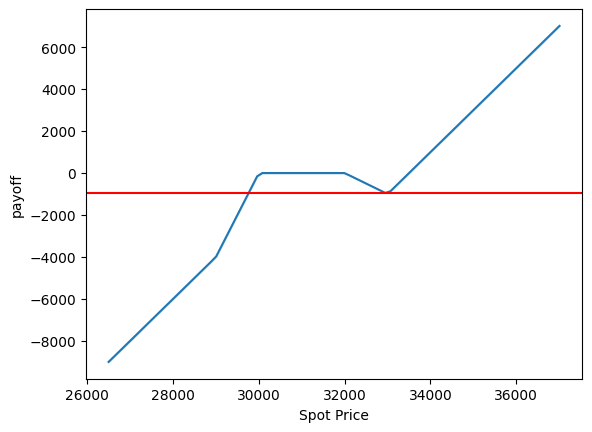

net premium -958.2588217803611
premium 2755.6979824847563
Risk Reward 0.9907290523551466
probal 0.6853932584269663
lowest possible premium -9003.06838588194
max risk [8.39523663]
worst case, vol: 0.85 price: 26498.46580705903
best case, vol: 0.85 price: 37005.98386701981
min theta -179.15238836807018
min vega -24.626844977395905
P_29000_2__P_30000_-4__C_32000_-1__C_33000_3
[{'type': 'P', 'strike': 29000.0, 'expiry': 0.01496075075767377, 'vol': 0.5418999999999999, 'quantity': 2, 'map': 1}, {'type': 'P', 'strike': 30000.0, 'expiry': 0.01496075075767377, 'vol': 0.4725, 'quantity': -4, 'map': -1}, {'type': 'C', 'strike': 32000.0, 'expiry': 0.01496075075767377, 'vol': 0.4849, 'quantity': -1, 'map': -1}, {'type': 'C', 'strike': 33000.0, 'expiry': 0.01496075075767377, 'vol': 0.5521, 'quantity': 3, 'map': 1}]


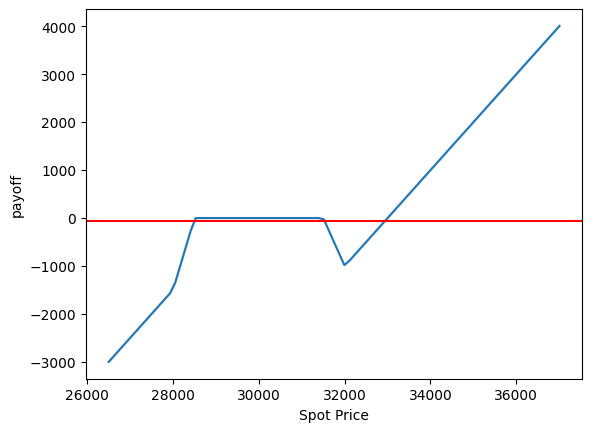

net premium -56.03447590782662
premium 2277.1078201880473
Risk Reward 1.3790591523190183
probal 0.6853932584269663
lowest possible premium -3001.5341929409697
max risk [52.56584753]
worst case, vol: 0.85 price: 26498.46580705903
best case, vol: 0.85 price: 37005.98386701981
min theta -98.11034650203614
min vega -14.160726089039139
P_28000_2__P_28500_-3__C_31500_-2__C_32000_3
[{'type': 'P', 'strike': 28000.0, 'expiry': 0.01496075075767377, 'vol': 0.5999, 'quantity': 2, 'map': 1}, {'type': 'P', 'strike': 28500.0, 'expiry': 0.01496075075767377, 'vol': 0.536, 'quantity': -3, 'map': -1}, {'type': 'C', 'strike': 31500.0, 'expiry': 0.01496075075767377, 'vol': 0.47700000000000004, 'quantity': -2, 'map': -1}, {'type': 'C', 'strike': 32000.0, 'expiry': 0.01496075075767377, 'vol': 0.5077, 'quantity': 3, 'map': 1}]


In [14]:
# bule line is the payoff curve, red line stands for net premium, yep this is for plotting
for para in temp.para[:5]:
    model.model_plot(para)